In [1]:
from huggingface_hub import login

login()

In [2]:
import pandas as pd
import datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_data = pd.read_csv('./described_dataset_label.csv',sep='\t',encoding='latin-1')
print(f'coumns:{[x for x in train_data.columns]}')

coumns:['FILE', 'AUTHOR', 'TECHNIQUE', 'URL']


In [5]:
features = ['FILE','AUTHOR','TECHNIQUE','URL']
train_data = train_data[features]
train_data = train_data[:1000]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(',').str[0]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(':').str[0]
train_data.head()

,FILE,AUTHOR,TECHNIQUE,URL
0,./images/1.jpg,"AACHEN, Hans von",Oil on copper,"The painting, displaying the characteristic Ma..."
1,./images/2.jpg,"AACHEN, Hans von",Oil on canvas,The representation of this group is related to...
2,./images/3.jpg,"AACHEN, Hans von",Copperplate,At the end of the 16th century the court of Em...
3,./images/4.jpg,"AACHEN, Hans von",Oil on canvas,Rudolf II (1552-1612) was the son of the Holy ...
4,./images/5.jpg,"AACHEN, Hans von",Oil on canvas,Hans von Aachen was an artist who fully embrac...


In [6]:
train_data.dropna()
train_data = train_data[train_data['URL'] != 0]

In [7]:
train_data = train_data.rename(columns={'FILE':'image','AUTHOR':'author', 'TECHNIQUE':'style','URL':'description'})

In [8]:
labels_auth = train_data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [9]:
labels_sty = train_data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [10]:
train_data['author'] = train_data['author'].map(label2id_auth)
train_data['style'] = train_data['style'].map(label2id_sty)
train_data.columns

Index(['image', 'author', 'style', 'description'], dtype='object')

In [11]:
train_dataset = datasets.Dataset.from_pandas(train_data).cast_column('image',datasets.Image())
train_dataset_git = datasets.Dataset.from_pandas(train_data[['image','description']]).cast_column('image',datasets.Image())
train_dataset_vit_auth = datasets.Dataset.from_pandas(train_data[['image','author']]).cast_column('image',datasets.Image())
train_dataset_vit_style = datasets.Dataset.from_pandas(train_data[['image','style']]).cast_column('image',datasets.Image())
print(train_dataset)

Dataset({
    features: ['image', 'author', 'style', 'description'],
    num_rows: 1000
})


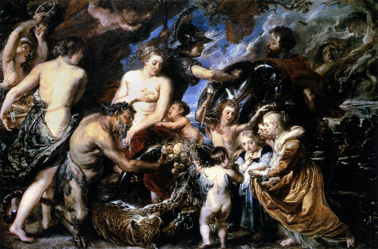

Description: The subject of this famous portrait - formerly thought to be a self-portrait - is an unknown young man looking up from his book.Daylight enters as if through a high and narrow window on our left. Brilliant on the gathered shirt, reflections from which define the curve of the jaw and the twist of the neck, it casts deep shadows on the eye sockets, smoulders in the dark eyes, shapes the skull under the triangular hat, lends mobility and colour to the distinctive features. The twisting pose is at once momentary and stable.
Author: 86
Technique: 1


In [12]:
sample = train_dataset[605]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']
author = sample['author']
technique = sample['style']
print(f'Description: {caption}')
print(f'Author: {author}')
print(f'Technique: {technique}')

In [14]:
from transformers import AutoModelForImageClassification

checkpoint = './model_checkpoints/model_auth'
model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at ./model_checkpoints/model_auth and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([109, 768]) in the checkpoint and torch.Size([115, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([109]) in the checkpoint and torch.Size([115]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import AutoModelForImageClassification

checkpoint = './model_checkpoints/model_sty'
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at ./model_checkpoints/model_sty and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([98, 768]) in the checkpoint and torch.Size([115, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([98]) in the checkpoint and torch.Size([115]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import AutoImageProcessor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint= 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [17]:
from transformers import AutoImageProcessor

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [18]:
from transformers import AutoProcessor
processor_capt = AutoProcessor.from_pretrained("microsoft/git-base-coco")

In [19]:
from transformers import AutoModelForCausalLM

model_capt = AutoModelForCausalLM.from_pretrained('./model_checkpoints/model_capt').to(device)

In [20]:
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the two prophets'statues flanking the central portal on the facade of the cathedral in fidenza, david on the left and ezekiel on the right, are standing in niches and are very rare examples of three - dimensional romanesque sculpture.


In [21]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])

ADRIANO FIORENTINO
ADLER, Salomon


In [22]:
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]
text="Make a More Detailed description using: " + predicted_label_auth+' '+predicted_label_sty + ' ' + generated_caption

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
access_token = ""

model_name = "meta-llama/Llama-2-7b-hf" 

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

inputs = tokenizer(text, return_tensors='pt')
output = model.generate(**inputs, penalty_alpha=0.6, top_k=4, max_new_tokens=100)
generated_text = tokenizer.batch_decode(output[-1], skip_special_tokens=True)
print(generated_text)

# Project Work

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = generated_text + " Using the style " + predicted_label_sty
images = pipe(prompt=prompt).images[0]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(images)
plt.show()